In [133]:
# All imported libraries
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam

## Loading data
This function loads all data into their own numpy arrays.

In [129]:
# Function that loads all required data in its own np array.
def load_and_preprocess_dataset():
    x_train = []
    y_train = []
    data = os.listdir('CarsSet/DATA/DATA/train')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/train', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_train.append(img)
        else:
            # Load the XML annotation file
            tree = ET.parse(os.path.join('CarsSet/DATA/DATA/train', image))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            bbox = []
            # Extract the xmin, ymin, xmax, and ymax values from the bndbox element
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Scale the bounding box coordinates to match the resized image
            height, width, _ = imgShape.shape
            scale_x = 224 / width
            scale_y = 224 / height
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            bbox.append(xmin)
            bbox.append(ymin)
            bbox.append(xmax)
            bbox.append(ymax)
            y_train.append(bbox)
    
    
    x_val = []
    y_val = []
    data = os.listdir('CarsSet/DATA/DATA/validate')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/validate', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_val.append(img)
        else:
            # Load the XML annotation file
            tree = ET.parse(os.path.join('CarsSet/DATA/DATA/validate', image))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            bbox = []
            # Extract the xmin, ymin, xmax, and ymax values from the bndbox element
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Scale the bounding box coordinates to match the resized image
            height, width, _ = imgShape.shape
            scale_x = 224 / width
            scale_y = 224 / height
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            bbox.append(xmin)
            bbox.append(ymin)
            bbox.append(xmax)
            bbox.append(ymax)
            y_val.append(bbox)


    x_test = []
    y_test = []
    data = os.listdir('CarsSet/DATA/DATA/test')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/test', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_test.append(img)
        else:
            # Load the XML annotation file
            tree = ET.parse(os.path.join('CarsSet/DATA/DATA/test', image))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            bbox = []
            # Extract the xmin, ymin, xmax, and ymax values from the bndbox element
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Scale the bounding box coordinates to match the resized image
            height, width, _ = imgShape.shape
            scale_x = 224 / width
            scale_y = 224 / height
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            bbox.append(xmin)
            bbox.append(ymin)
            bbox.append(xmax)
            bbox.append(ymax)
            y_test.append(bbox)

    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)


In [192]:
# Load and preprocess the dataset
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_and_preprocess_dataset()

## Neural network
In the following code I make a model based on the VGG16 model from Keras. For detecting cars in images, the VGG16 model can be fine-tuned on a dataset of car images, where the last fully connected layer is replaced with a new output layer that predicts the bounding box coordinates of the car in the image. The pre-trained weights of the model can then be fine-tuned on this new task, which allows the model to learn to detect cars in images with high accuracy.

To fine-tune the VGG16 model I dont include the top classification layer and make it myself. 

In [197]:
# Get the input shape from X_train
input_shape = X_train.shape[1:]

# Load VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a flatten layer and a dense layer for classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(4, activation='linear')(x)

# Create a new model with input and output layers, so that only the weights of the new top classification layer will be updated during training.
model = Model(inputs=base_model.input, outputs=output)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Training the Model


In [198]:
# Train the model
hist = model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val))

Train on 269 samples, validate on 28 samples
Epoch 1/10
269/269 [==============================] - 56s 209ms/step - loss: 7338.5182 - mean_squared_error: 7338.5182 - val_loss: 2626.1355 - val_mean_squared_error: 2626.1355
Epoch 2/10
269/269 [==============================] - 52s 194ms/step - loss: 3505.0337 - mean_squared_error: 3505.0337 - val_loss: 1288.6423 - val_mean_squared_error: 1288.6423
Epoch 3/10
269/269 [==============================] - 52s 195ms/step - loss: 1287.2189 - mean_squared_error: 1287.2189 - val_loss: 902.5626 - val_mean_squared_error: 902.5626
Epoch 4/10
269/269 [==============================] - 52s 195ms/step - loss: 590.9275 - mean_squared_error: 590.9275 - val_loss: 726.6117 - val_mean_squared_error: 726.6117
Epoch 5/10
269/269 [==============================] - 52s 194ms/step - loss: 285.7326 - mean_squared_error: 285.7326 - val_loss: 494.6197 - val_mean_squared_error: 494.6197
Epoch 6/10
269/269 [==============================] - 52s 195ms/step - loss: 140

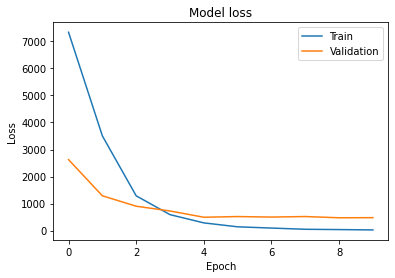

In [199]:
# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [101]:
# Save the model
model.save("improved_model.h5")

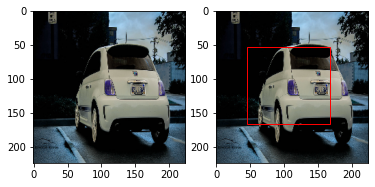

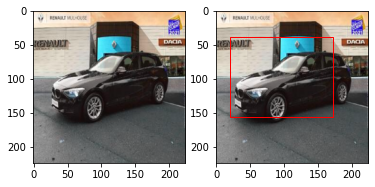

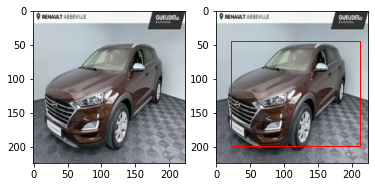

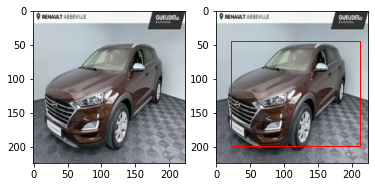

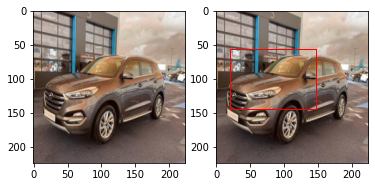

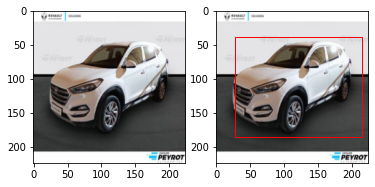

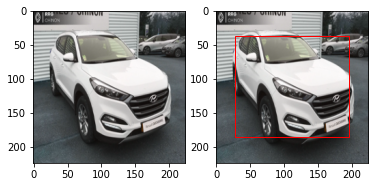

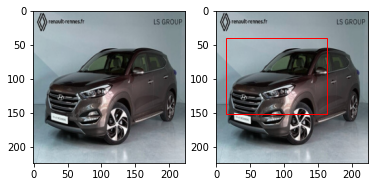

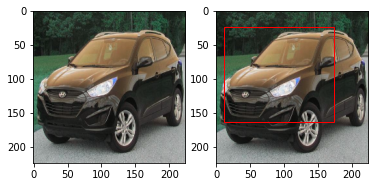

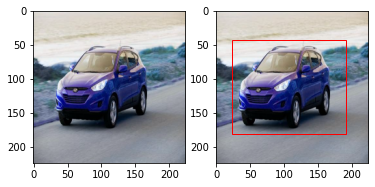

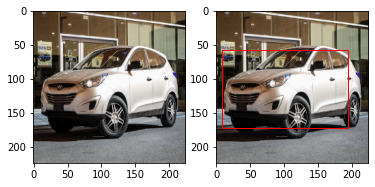

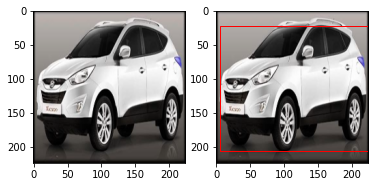

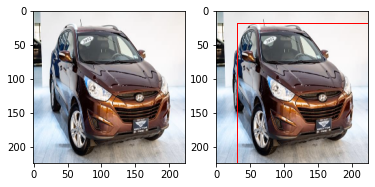

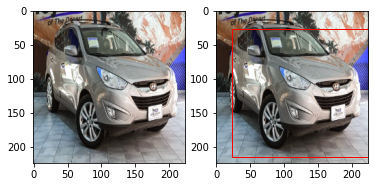

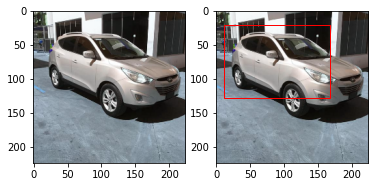

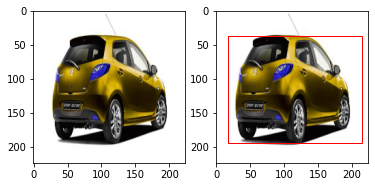

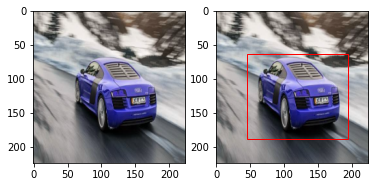

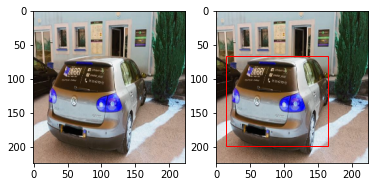

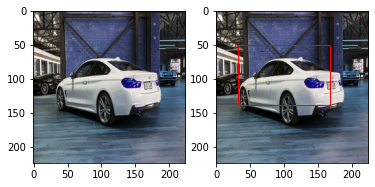

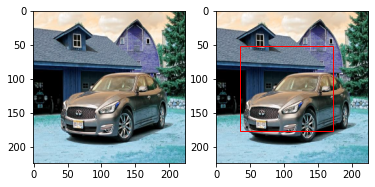

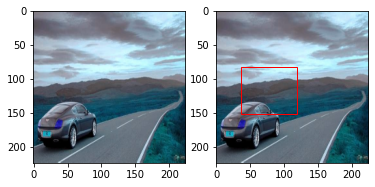

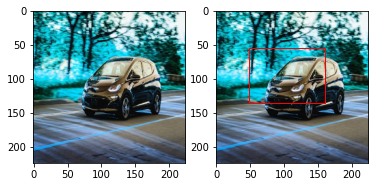

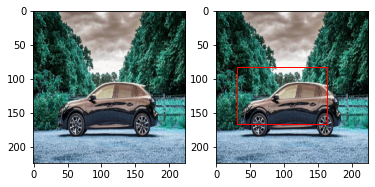

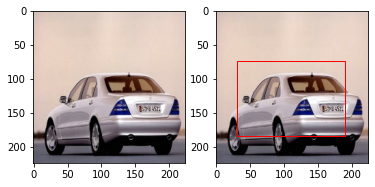

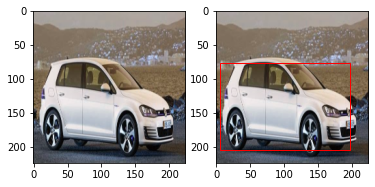

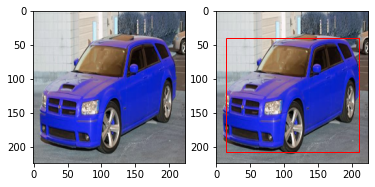

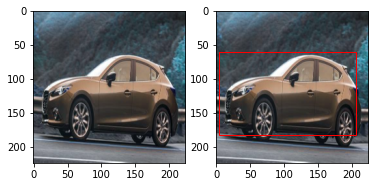

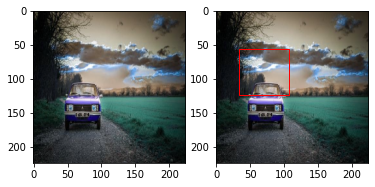

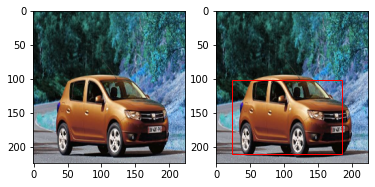

In [200]:
# Display one image without and one image with bounding boxes.
def display_image(path, x1, y1, x2, y2):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(path)
    ax[1].imshow(path)
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
    plt.show()


# Loop through the image filenames and process each image
for index in range(len(X_test)):
    image = np.expand_dims(X_test[index], axis=0)
    preds = model.predict(image)
    x1, y1, x2, y2 = preds.astype('int')[0]
    display_image(X_test[index], x1, y1, x2, y2)
